In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import cv2

La biblioteca rasterio se usapoder utilizar las imágenes georreferenciadas multibanda y convertirlas a arreglos NumPy.

# Cargar imagen y dividir sus bandas

El archivo es una imagen satelital de Sentinel 2 de la ciudad de Palmira, Valle del Cauca - Colombia.

"El compuesto [infrarrojo de color falso](https://custom-scripts.sentinel-hub.com/sentinel-2/false_color_infrared/) mapea la banda espectral B8 del infrarrojo cercano con las bandas roja y verde, B4 y B3, a componentes sRGB directamente." En el caso de Sentinel 2, se usan las bandas B8, B4 y B2

A pesar de que este tipo de composición se utilza para evaluar la salud en las plantas, podemos aprovechar el hecho de que en esta imagen se diferencia bastante bien entre las construcciones de la ciudad, terrenos baldíos y vegetación. Por lo que lo usaremos para determinar la huella urbana de la ciudad de Palmira, incluyendo las construcciones de pequeños poblados a las afueras de la ciudad.

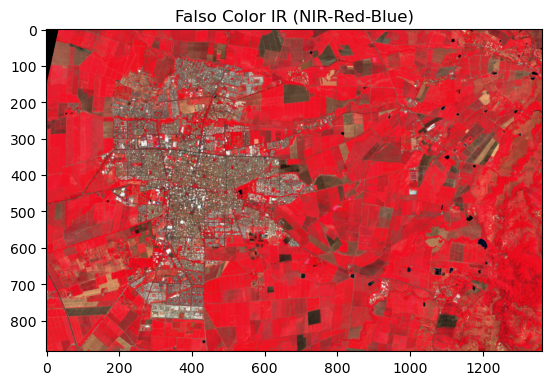

In [2]:
# Nombre de la imagen
ruta_imagen = "2024-08-30-00_00_2024-08-30-23_59_Sentinel-2_L2A_False_color.tiff"

with rasterio.open(ruta_imagen) as src:
    nir  = src.read(1).astype(np.float32)   # B8
    red  = src.read(2).astype(np.float32)   # B4
    blue = src.read(3).astype(np.float32)   # B2

    
# Mapeo a R, G, B => (nir, red, blue)
false_color = np.dstack([nir, red, blue])
false_color_norm = false_color / np.nanmax(false_color)

plt.imshow(false_color_norm)
plt.title("Falso Color IR (NIR-Red-Blue)")
plt.show()

En la imagen se puede notar que la vegetación refleja bien el infrarrojo. Las ciudades y los terrenos baldíos o despejados tienen un color gris o durazno tostado. El agua se muestra azul o negra. 

# Cálculo del NDVI
Para diferenciar zonas con vegetación de la ciudad

El índice de vegetación de diferencia normalizada es un índice sencillo pero eficaz para cuantificar la vegetación verde.

El objetivo de calcular este índice es que este tiene un valor alto en zonas con alta vegetación y es bajo para zonas construídas o desiertas. Por lo que nos permitiría luego filtrar o descartar la vegetación para concentrarnos en las construcciones de la ciudad y circundantes.

La fórmula para calcular el NDVI es:
$$
\text{NDVI} = \frac{\text{NIR} + \text{RED}}{\text{NIR} - \text{RED}}
$$


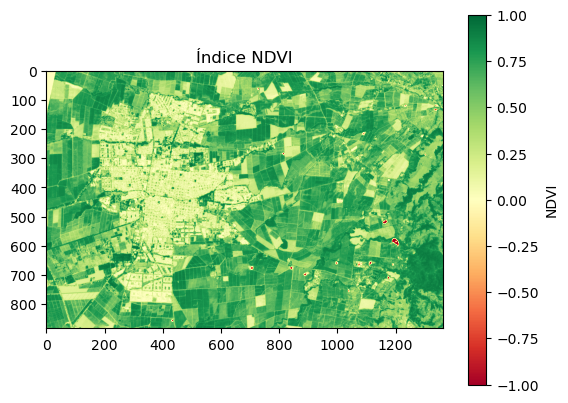

In [3]:
ndvi = (nir - red) / np.where((nir + red) == 0, 1, (nir + red))

plt.imshow(ndvi, cmap='RdYlGn')
plt.colorbar(label="NDVI")
plt.title("Índice NDVI")
plt.show()


# Umbralización: diferenciar entre vegetación y posibles áreas urbanizadas

Creamos una máscara binaria para tener una definición preliminar de lo que es o no urbanización.

Si es posiblemente urbano, se pone blanco.


Si no es urbano, se pone negro.


Para esto usamos el índice UDVI calculado anteriormente, y lo comparamos con nuestro umbral. Este umbral se movió empíricamente hasta 0.25, donde dio mejores resultados aparentes.


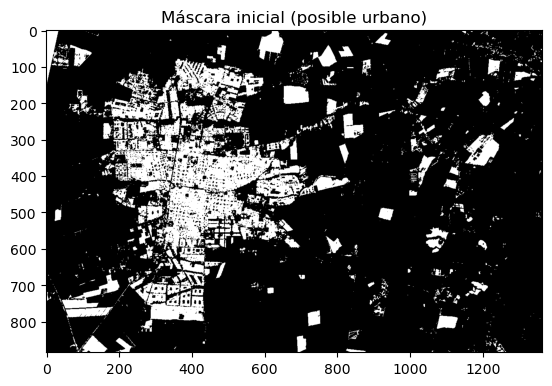

In [4]:
# Definir umbral para NDVI
ndvi_threshold = 0.25

# Crear máscara binaria: 1 si NDVI < 0.3 (posible urbano), 0 caso contrario
# np.uint8 es un entero sin signo entre 0 y 255. 
# De este modo, si la condición de que sea posiblemente urbano se cumple, el resultado se pasa a 255 (blanco); 
# de lo contrario, se redondea a 0 (negro)
urban_mask = (ndvi < ndvi_threshold).astype(np.uint8)

plt.imshow(urban_mask, cmap='gray')
plt.title("Máscara inicial (posible urbano)")
plt.show()

Se pueden notar muchos recuadros notados como posible urbanización. Si nos remitimos a la imagen original, podremos ver que son terrenos de cultivos baldíos, quemados o cosechados, por lo que próximamente tendremos que deshacernos de ellos.

# Filtro Morfológico

Vamos a evitar usar el filtro de apertura porque no dio buenos resultados: Elimina los puntos recuadros chicos que pueden ser poblados pequeños.


Como también nos importan los poblados pequeños, solo usaremos el filtro de clausura, que también nos ayuda a conectar estructuras contiguas que hayan sido segmentadas.

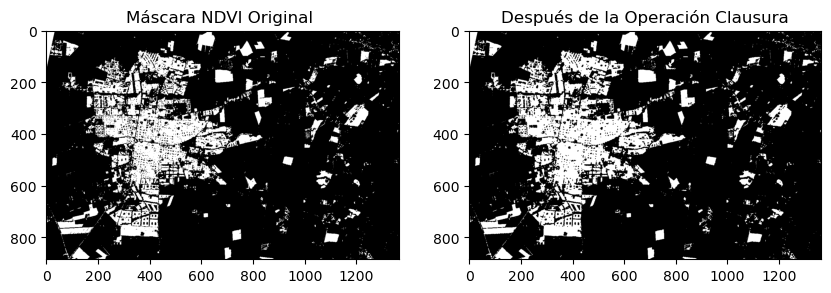

In [5]:
# Se usa un elemento estructural de elipse / vendría siendo el equivalente al hexagonal
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))

# Aplicar solo clausura
mask_closed = cv2.morphologyEx(urban_mask, cv2.MORPH_CLOSE, kernel)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(urban_mask, cmap='gray')
plt.title("Máscara NDVI Original ")

plt.subplot(1,2,2)
plt.imshow(mask_closed, cmap='gray')
plt.title("Después de la Operación Clausura")
plt.show()

urban_mask_step = mask_closed.copy()


# Máscara o filtro de textura para poder eliminar los suelos de cultivos vacíos o secos

Como se mencionaba anteriormente, hay un problema para poder avanzar en la segmentación, y es que los terrenos de cultivos secos, terrenos baldíos o grandes extensiones de tierra sin vegetación abundante, también están apareciendo en la segmentación.

Debido a esto, se decidió usar un **filtro de textura**. Esto es útil porque las zonas urbanizadas suelen ser más heterogéneas o presentar mayor textura que una zona baldía, donde las grandes extensiones de tierra son más o menos homogéneas.

## Cálculo de la desviación estándar

Se calcula primero la **desviación estándar** de una pequeña ventana o máscara que recorrerá toda la imagen.

Cuanto mayor sea la desviación, mayor “heterogeneidad” local habrá, y por lo tanto más chance de que sea una zona construida.

En el caso contrario, se considerará como una zona baldía o no construída.

**Nota**: el tamaño de la ventana fue tomado empíricamente, considerando el valor que diera resultados más detallados y que pudiera distinguir mejor a los techos de un solo color que podrían desaparecer de otro modo.

**Nota**: De este paso, se logran escapar algunas estructuras que vienen siendo los rebordes de zonas de cultivo aradas o quemadas. Pero que logranpasar luego el umbral de textura. Sin embargo, estos son los mejores resultados obtenidos.

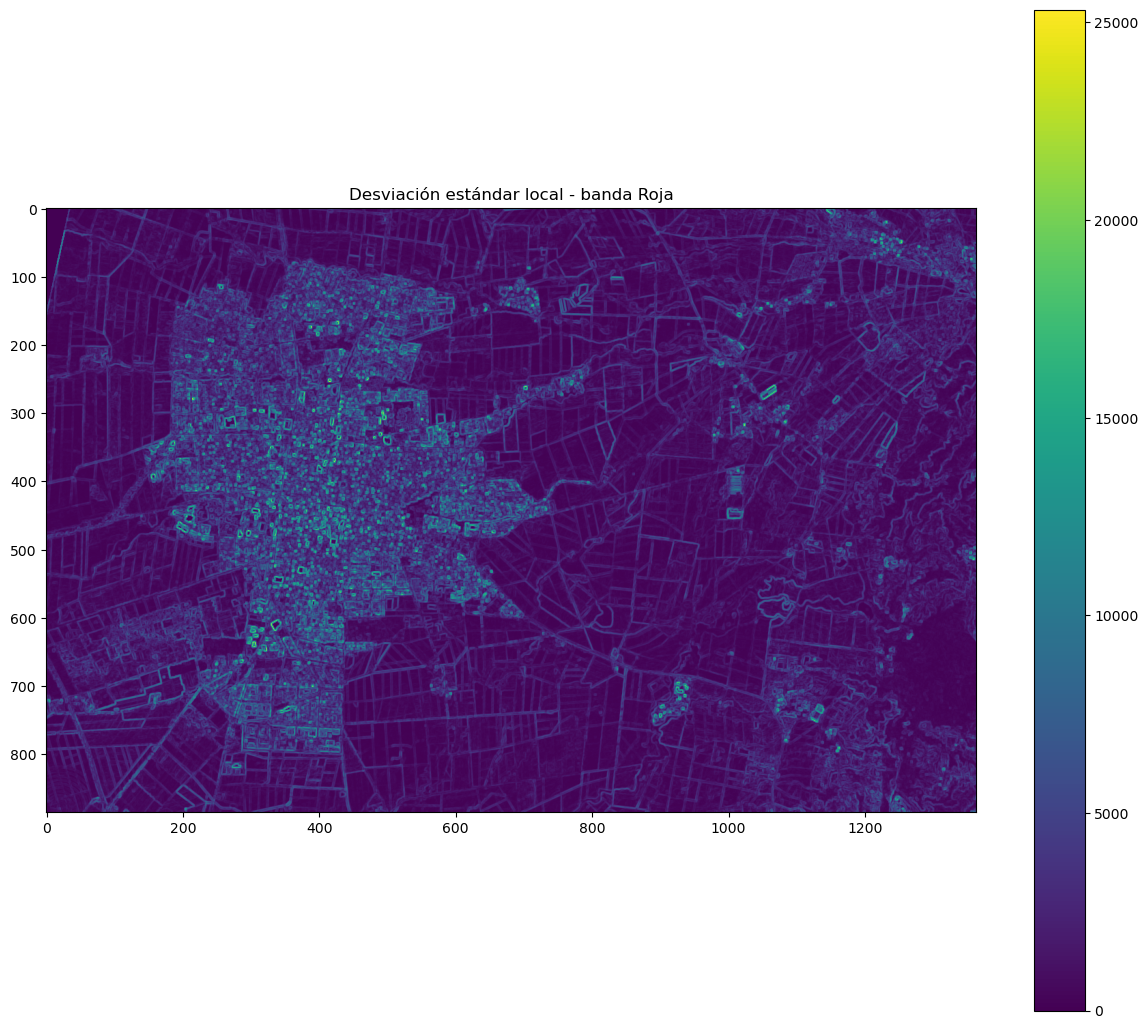

<Figure size 1200x800 with 0 Axes>

In [6]:
from scipy.ndimage import generic_filter

# Se usa la banda roja (red):
def local_std(values):
    return np.std(values)

# Tamaño de la ventana
size = 3

# Calculamos std local en la banda roja
red_std = generic_filter(red, local_std, size=size)

plt.figure(figsize=(15, 13))
plt.imshow(red_std, cmap='viridis')
plt.title("Desviación estándar local - banda Roja")
plt.colorbar()
plt.figure(figsize=(12, 8))
plt.show()


## Mapa de segmentación de la textura

A partir del mapa de desviación anterior, podemos hacer una nueva segmentación binaria para determinar las zonas donde es más probable que hayan construcciones, calles, y otras estructuras propias de las ciudades.

**Nota**: La esquina superior izquierda de la imagen original tiene una ausencia de valores porque hasta ahí llega la foto satelital, por lo que a la hora de aplicar este filtro, los valores bajos solo resaltaban la ausencia de valores en esa zona de la imagen. Por lo que hubo que elevar el threshold hasta 3000, donde se obtenían mejores resultados empíricos. 

**Nota**: Si se baja demasiado el threshold, habrán muchos más elementos de los deseados en el resultado final; si se sube demasiado, se desaparecen pequeñas variaciones importantes como pequeñas casas o calles.

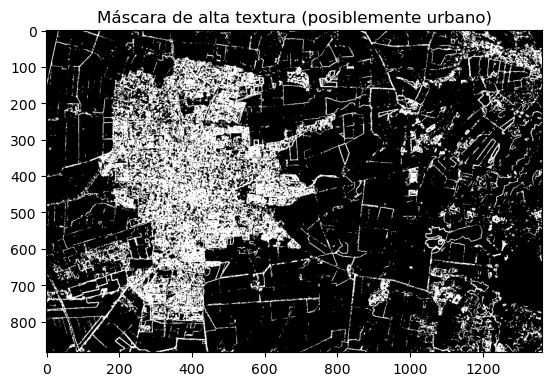

In [7]:
texture_threshold = 3000
mask_texture = (red_std > texture_threshold).astype(np.uint8)

plt.imshow(mask_texture, cmap='gray')
plt.title("Máscara de alta textura (posiblemente urbano)")
plt.show()


### Combinar la máscara NDVI con la máscara de textura

Con este paso se pretende converger los pasos anteriores, en que se detecta las zonas con vegetación usando el NDVI, y las zonas con estructuras o textura.

* Si la zona no tiene vegetación (NDVI < 0.3) + “alta textura” (red_std > 3000) = posiblemente urbano.
* Las zonas sin vegetación y homogéneas, corresponderán entonces a terrenos baldíos, suelos de cultivo quemados, arados o sin plantas. Por lo tanto, se excluirán.

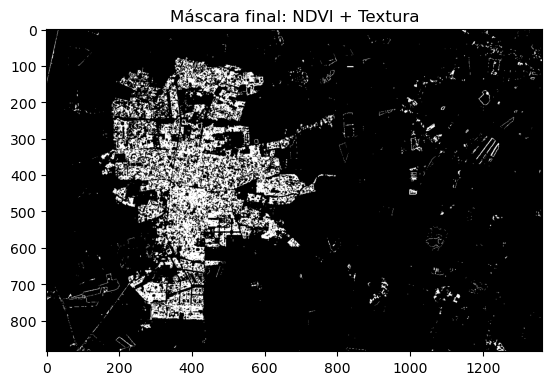

In [8]:
final_mask = (urban_mask_step * mask_texture).astype(np.uint8)

plt.imshow(final_mask, cmap='gray')
plt.title("Máscara final: NDVI + Textura")
plt.show()


En esta máscara se puede notar que hay algunos rebordes que corresponden a parcelas baldías, que lograron pasar el umbral en las operaciones anteriores. Sin embargo, por practicidad, se tolerarán estos errores, ya que a la hora de segmentar y delimitar los bordes, son fácilmente identificables y son pocos casos.

Además, con estos parámetros también se asegura que entren poblados o asentamientos pequeños en la zona rural, que de otro modo hubieran sido excluídos y que son importantes para el caso de estudio planteado.

## Filtrar por conectividad sin eliminar objetos pequeños

Se van a filtrar píxeles sueltos muy pequeños que realmente no sean útiles y que no representen poblados, sin perder las zonas rurales con asentamientos.
Por esto, no se debe usar un area_min muy alta, ya que si el área de píxeles es muy grande puede tener el tamaño suficiente como para eliminar casas sueltas.

**Nota**: Se usa cv2.connectedComponents, ya que este permite determinar la conectividad de las regiones de la máscara binaria con detalle. De modo que luego se pueda establecer si al recorrer la imagen, ciertas zonas pueden ser descartadas teniendo en consideración el área mínima.

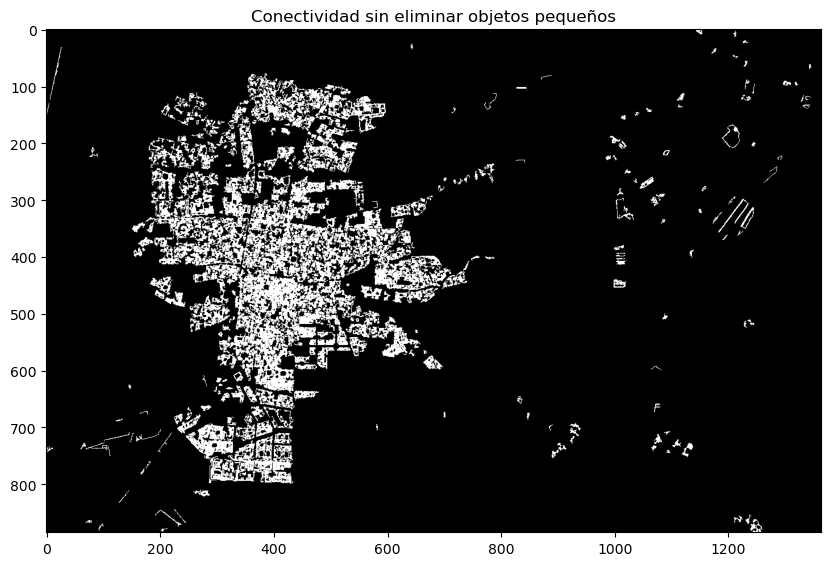

In [9]:
num_labels, labels_im = cv2.connectedComponents(final_mask)

# Ajustamos un area_min baja para no perder asentamientos pequeños
area_min = 20
mask_conn = np.zeros_like(final_mask)

for label_num in range(1, num_labels):
    component = (labels_im == label_num)
    area = np.sum(component)
    if area >= area_min:
        mask_conn[component] = 1
        
plt.figure(figsize=(10, 9))
plt.imshow(mask_conn, cmap='gray')
plt.title("Conectividad sin eliminar objetos pequeños")
plt.show()

urban_final_mask = mask_conn


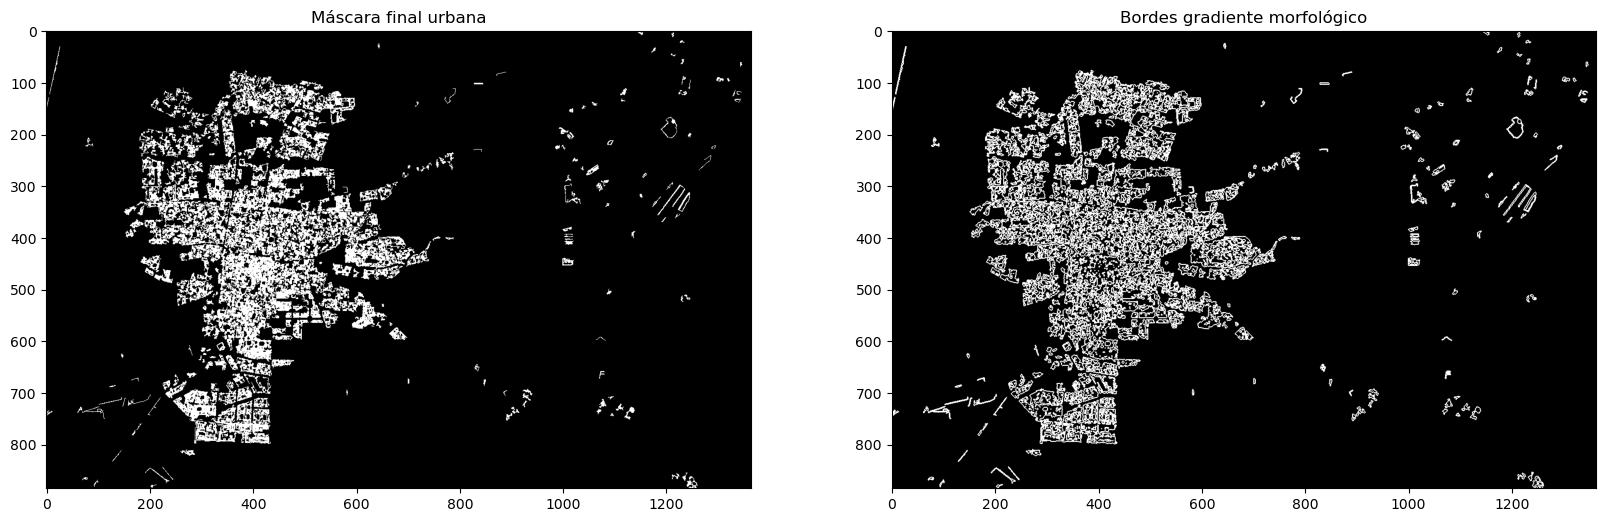

In [10]:
# Se usa la máscara binaria final urban_final_mask (0 y 1)
mask = urban_final_mask.astype(np.uint8)

# Erodemos la máscara
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
eroded_mask = cv2.erode(mask, kernel)

# El contorno se determina con el gradiente morfológico
border_mask_gradient = cv2.morphologyEx(mask, cv2.MORPH_GRADIENT, kernel)

plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(mask, cmap="gray")
plt.title("Máscara final urbana")

plt.subplot(1,2,2)
plt.imshow(border_mask_gradient, cmap="gray")
plt.title("Bordes gradiente morfológico")
plt.show()


## Superponer la máscara final con la imagen inicial

Para comparar los resultados de la segmentación contra la imagen original

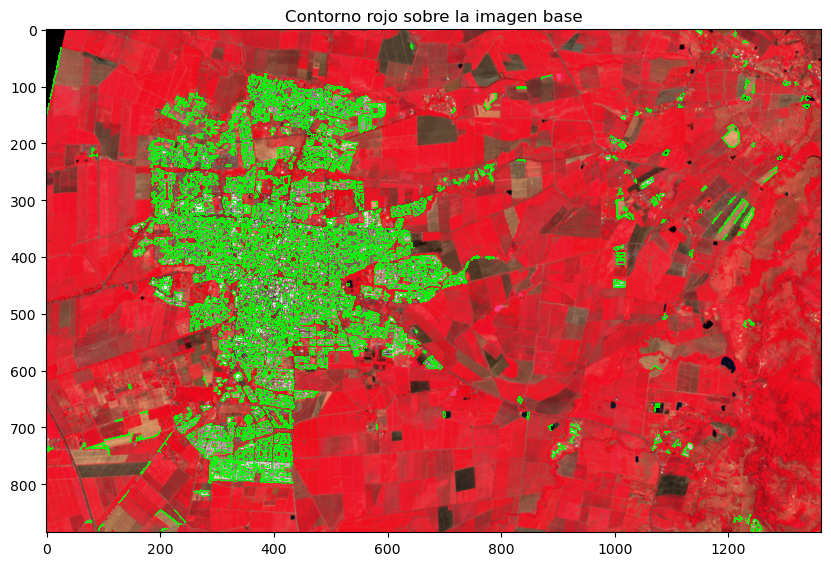

In [11]:
from matplotlib.colors import ListedColormap

# Creamos un cmap con 2 colores: [1] Transparente, [2] Lima
cmap_borde = ListedColormap(["none", "lime"])

border_mask_norm = (border_mask_gradient / 255).astype(np.uint8)

plt.figure(figsize=(10, 10))
plt.imshow(false_color_norm)
plt.imshow(border_mask_gradient, cmap=cmap_borde, alpha=0.9, vmin=0, vmax=1)

# Guardar imagen
plt.savefig("resultado_bordes_overlay_Palmira.png", bbox_inches='tight', dpi=150)

plt.title("Contorno rojo sobre la imagen base")

plt.show()
plt.close()


# Conclusiones

En la imagen final se puede apreciar la máscara con los bordes, en verde lima, superpuestos a la imagen original. 

Se recuperan pequeños poblados a las afueras de la ciudad, que a simple vista son difíciles de detectar.

Hay qu resaltar que hay algunas zonas de cultivo secas que se filtraron hasta el final, esto probablemente porque pasaron el filtro hecho durante el cálculo de desviaciones para hallar las texturas en la imagen. Si se subía el threshold para estos casos, se perdían segmentos de edificios incluso dentro de la ciudad, por lo que se decidió conservarlo de esta forma.

Se adjunta imagen de Palmira en vista satelital con color real optimizado resaltado, a modo de ilustración comparativa.

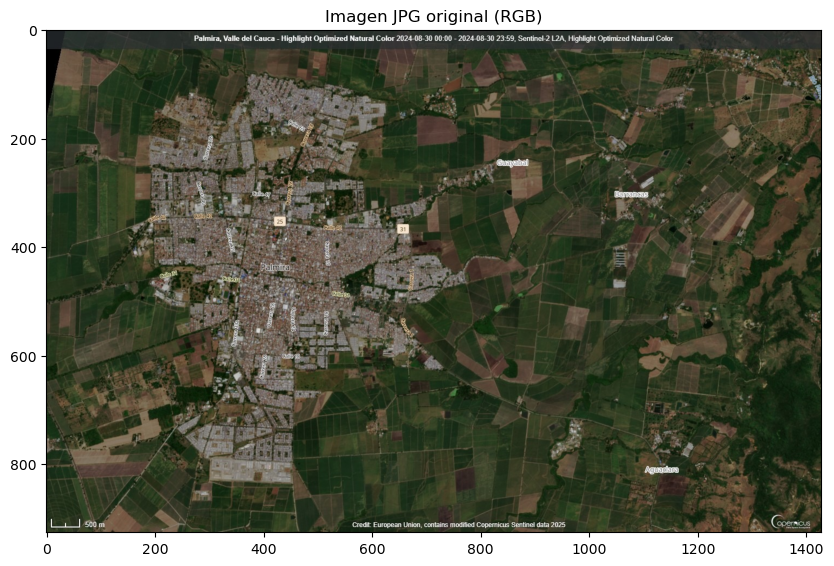

In [12]:
ruta_imagen_coloreada = "2024-08-30-00_00_2024-08-30-23_59_Sentinel-2_L2A_Highlight_Optimized_Natural_Color.jpg"

# Lee la imagen en BGR
img_bgr = cv2.imread(ruta_imagen_coloreada)  
# Convierte a RGB para visualizar en matplotlib
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(img_rgb)
plt.title("Imagen JPG original (RGB)")
plt.show()